# Seed


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from numpy.random import seed
seed(3)

# Import de fonctions

In [ ]:
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import adjusted_rand_score as ARI
from sklearn.metrics import adjusted_mutual_info_score as AMI
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import v_measure_score
from skimage.transform import resize
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler
from scipy.stats import wasserstein_distance
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np
import datetime
import torch
import sys
from scipy.special import logsumexp
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
from torch.optim.lr_scheduler import StepLR
from matplotlib.patches import Patch
from sklearn.preprocessing import normalize
!pip install umap-learn
import umap
from sklearn.manifold import TSNE
import plotly.express as px

# Dataset des chiffres du MNIST
from keras.datasets import mnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 6.7 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=a8ac7635b876dc0929cfa3e733b31440d071c5127e27f0f366fb9ea678ae5171
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn


In [ ]:
@torch.no_grad()
def distributed_sinkhorn(out, epsilon=0.05, sinkhorn_iterations=15):
    Q = torch.exp(out / epsilon).t() # Q is K-by-B for consistency with notations from our paper
    B = Q.shape[1] # / world_size  # number of samples to assign
    K = Q.shape[0] # how many prototypes

    # make the matrix sums to 1
    sum_Q = torch.nansum(Q)
    Q /= (sum_Q + 1e-5)

    for it in range(sinkhorn_iterations):
        # normalize each row: total weight per prototype must be 1/K
        sum_of_rows = torch.nansum(Q, dim=1, keepdim=True)
        Q /= (sum_of_rows + 1e-5)
        Q /= (K + 1e-5)

        # normalize each column: total weight per sample must be 1/B
        Q /= torch.nansum(Q, dim=0, keepdim=True)
        Q /= (B + 1e-5)

    Q *= B  # the columns must sum to 1 so that Q is an assignment
    return Q.t()


In [ ]:
colors_per_cluster = {
                      -1:np.array([0.4,0.4,0.4]),
                      0:np.array([0.9,0.05,0.05]),
                      1:np.array([0.15,0.15,0.85])
                      }

# scale and move the coordinates so they fit [0; 1] range
def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))
    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)
    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range

# Compute the coordinates of the image on the plot
def compute_plot_coordinates(image, x, y, image_centers_area_size, offset=8):
    image_height, image_width, _ = image.shape
    # compute the image center coordinates on the plot
    center_x = int(image_centers_area_size * x) + offset
    # in matplotlib, the y axis is directed upward
    # to have the same here, we need to mirror the y coordinate
    center_y = int(image_centers_area_size * (1 - y)) + offset
    # knowing the image center,
    # compute the coordinates of the top left and bottom right corner
    tl_x = center_x - int(image_width / 2)
    tl_y = center_y - int(image_height / 2)
    br_x = tl_x + image_width
    br_y = tl_y + image_height
    return tl_x, tl_y, br_x, br_y

def draw_rectangle_by_conditional_pred(image, label_pred_conditionnaly_to_cluster, plot_neg=True, false_pred=False) :
  image = np.stack((image,)*3, axis=-1)

  if false_pred :
    color = np.array([0.05,1,0.05])
  elif plot_neg :
    color = colors_per_cluster[0]*label_pred_conditionnaly_to_cluster[0] + colors_per_cluster[-1]*(1-label_pred_conditionnaly_to_cluster[0])
    color += colors_per_cluster[1]*label_pred_conditionnaly_to_cluster[1] + colors_per_cluster[-1]*(1-label_pred_conditionnaly_to_cluster[1])
    color = color / 2
  else :
    color = colors_per_cluster[0]*label_pred_conditionnaly_to_cluster[0]
    color += colors_per_cluster[1]*label_pred_conditionnaly_to_cluster[1]
  image[:2,:,:] = color
  image[:,-2:,:] = color
  image[-2:,:,:] = color
  image[:,:2,:] = color
  return image

def create_visualization(two_dim_latent_space, X_test, y_test, y_ground_truth, y_pred) :
  img_dim = 32
  offset = img_dim // 2 + 1
  huge_image_size = 2*250

  # extract x and y coordinates representing the positions of the images on T-SNE plot
  two_dim_latent_space = sklearn.preprocessing.RobustScaler().fit_transform(two_dim_latent_space)
  tx = two_dim_latent_space[:, 0]
  ty = two_dim_latent_space[:, 1]
  tx = scale_to_01_range(tx)
  ty = scale_to_01_range(ty)

  # init the plot as white canvas
  tsne_plot = np.ones((huge_image_size+2*offset+1, huge_image_size+2*offset+1, 3))

  c=0
  t=0
  # now we'll put a small copy of every image to its corresponding latent space coordinate
  for image, label, pred, x, y in zip(X_test, y_test, y_pred, tx, ty) :
      if label != 7 :
        if np.random.uniform(0,1) > 0.99 :
          continue
      elif c >= len(y_ground_truth) :
        continue
      else :
        cluster=y_ground_truth[c]
        c+=1
      image = np.reshape(image, (img_dim,img_dim))
      if label==7 and  cluster==0 :
        image = draw_rectangle_by_conditional_pred(image, {0:0, 1:1}, plot_neg=False)
      if label==7 and cluster==1 :
        image = draw_rectangle_by_conditional_pred(image, {0:1, 1:0}, plot_neg=False)
      if label!=7 :
        image = draw_rectangle_by_conditional_pred(image, {0:0, 1:0})
      # compute the coordinates of the image on the scaled plot visualization
      tl_x, tl_y, br_x, br_y = compute_plot_coordinates(image, x, y, huge_image_size)
      # put the image to its t-SNE coordinates using numpy sub-array indices
      if np.sum(tsne_plot[tl_y:br_y, tl_x:br_x])/3 > (img_dim**2-(offset-1)**2) :
        tsne_plot[tl_y:br_y, tl_x:br_x, :] = image
        t=t+1


  fig = plt.figure(figsize=(10, 10))

  legend_elements = [Patch(label='Negative class', fill=False, edgecolor='#999999', linewidth=3),
                    Patch(label='Subgroup 0', fill=False, edgecolor='b', linewidth=3),
                    Patch(label='Subgroup 1', fill=False, edgecolor='r', linewidth=3),]

  plt.axis('off')
  # plt.legend(handles=legend_elements, loc='lower right', prop={'size': 10})
  plt.imshow(tsne_plot)
  plt.show()


In [ ]:
# load ground truth label
import json

label_mapping_seven = {'No bar':0, 'With bar':1}
with open("/content/drive/MyDrive/Neurospin/Thèse Robin/UCSL/mnist_labels.json") as json_file:
    ground_truth_dict = json.load(json_file)
    y_ground_truth = np.array([label_mapping_seven[ground_truth_dict[key]] for key in ground_truth_dict.keys()])

# Define models and datasets

In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torchvision.models as models
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import torch

pos_label = 7

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = np.array([np.pad(img, 2) for img in X_train])
X_test = np.array([np.pad(img, 2) for img in X_test])

train_indices = []
test_indices = []

c=0
for (i, y_i) in enumerate(y_train) :
  if y_i in [pos_label] :
    train_indices.append(i)
    c+=1
  else :
    if len(train_indices) < 2*c :
      train_indices.append(i)

c=0
for (i, y_i) in enumerate(y_test) :
  if y_i in [pos_label] :
    test_indices.append(i)
    c+=1
  else :
    if len(test_indices) < 2*c :
      test_indices.append(i)

train_indices = np.array(train_indices)
test_indices = np.array(test_indices)

X_train = X_train[train_indices]
X_test = X_test[test_indices]
y_train = y_train[train_indices]
y_test = y_test[test_indices]

# flatten the images
n_samples_train = len(X_train)
X_train = X_train.reshape((n_samples_train, -1))
X_train = X_train - np.min(X_train, 1)[:, None]
X_train = X_train / np.max(X_train, 1)[:, None]

n_samples_test = len(X_test)
X_test = X_test.reshape((n_samples_test, -1))
X_test = X_test - np.min(X_test, 1)[:, None]
X_test = X_test / np.max(X_test, 1)[:, None]

X_train = np.array(X_train).astype(np.float)
X_test = np.array(X_test).astype(np.float)
y_train = np.array(y_train).astype(np.float)
y_test = np.array(y_test).astype(np.float)

X_train = np.reshape(X_train, (-1, 32, 32))
X_test = np.reshape(X_test, (-1, 32, 32))

X_train = X_train[y_train==7]
X_test = X_test[y_test==7]

11490434/11490434 [==============================] - 0s 0us/step


<ipython-input-7-8edbd5ae97bc>:58: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_train = np.array(X_train).astype(np.float)
<ipython-input-7-8edbd5ae97bc>:59: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_test = np.array(X_test).astype(np.float)
<ipython-input-7-8edbd5ae97bc>:60: DeprecationWarning: `np.float` is a deprecated alias fo

In [ ]:
print(X_train.shape)

(6265, 32, 32)


In [ ]:
class MyDataset(Dataset):
    def __init__(self, data, test=False):
        self.data = data
        self.transform = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.RandomRotation(25),
                            transforms.RandomAffine(15, translate=(0.1, 0.1), shear=0.1),
                        ])
        self.test = test

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        if not self.test :
          x_1 = self.transform(x).float()
        else :
          x_1 = torch.tensor(x)[None,:,:].float()
        x_2 = self.transform(x).float()
        return x_1.cuda(), x_2.cuda()


In [ ]:
# Simple
class SimpleConditionalConvNet(nn.Module):
    def __init__(self, nc, nz, n_clusters, kernel_size=7):
        super(SimpleConditionalConvNet, self).__init__()
        padding = kernel_size // 2
        layers = [
            nn.Conv2d(nc, 16, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 32, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        ]
        self.extracter = nn.Sequential(*layers)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc_head = nn.Sequential(nn.Linear(128, nz), nn.ReLU(), nn.Linear(nz, nz))
        self.fc_pred = nn.Sequential(nn.Linear(nz, nz), nn.ReLU(), nn.Linear(nz, nz))
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        encoded_vectors = self.extracter(x)
        encoded_vectors = self.avgpool(encoded_vectors)
        encoded_vectors = torch.flatten(encoded_vectors, 1).view(encoded_vectors.size(0), -1)
        encoded_head = self.fc_head(encoded_vectors)
        encoded_pred = self.fc_pred(encoded_head)
        return encoded_vectors, encoded_head, encoded_pred

class EMA():
    def __init__(self, alpha):
        super().__init__()
        self.alpha = alpha

    def update_average(self, old, new):
        if old is None:
            return new
        return old * self.alpha + (1 - self.alpha) * new

ema = EMA(0.99)
temperature = 0.1

# model parameters
nz = 128
nc = 1
n_clusters=2

# BYOL

Epoch: 1 	Training Loss: -18.564589
Epoch: 2 	Training Loss: -36.209329
Epoch: 3 	Training Loss: -52.923117
Epoch: 4 	Training Loss: -69.736546
Epoch: 5 	Training Loss: -86.680212
Epoch: 6 	Training Loss: -103.096993
Epoch: 7 	Training Loss: -118.750698
Epoch: 8 	Training Loss: -133.618919
Epoch: 9 	Training Loss: -147.382104
Epoch: 10 	Training Loss: -159.812194
Epoch: 11 	Training Loss: -171.240476
Epoch: 12 	Training Loss: -182.315543
Epoch: 13 	Training Loss: -192.469889
Epoch: 14 	Training Loss: -200.839740
Epoch: 15 	Training Loss: -207.889585
Epoch: 16 	Training Loss: -213.937845
Epoch: 17 	Training Loss: -219.194252
Epoch: 18 	Training Loss: -223.830621
Epoch: 19 	Training Loss: -227.873090
Epoch: 20 	Training Loss: -231.256724
Epoch: 21 	Training Loss: -234.119995
Epoch: 22 	Training Loss: -236.544932
Epoch: 23 	Training Loss: -238.576952
Epoch: 24 	Training Loss: -240.289179
Epoch: 25 	Training Loss: -241.737192


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


------------------------------------------------------------------
KM balanced accuracy score with hand-crafted labels :  0.5608624173716478


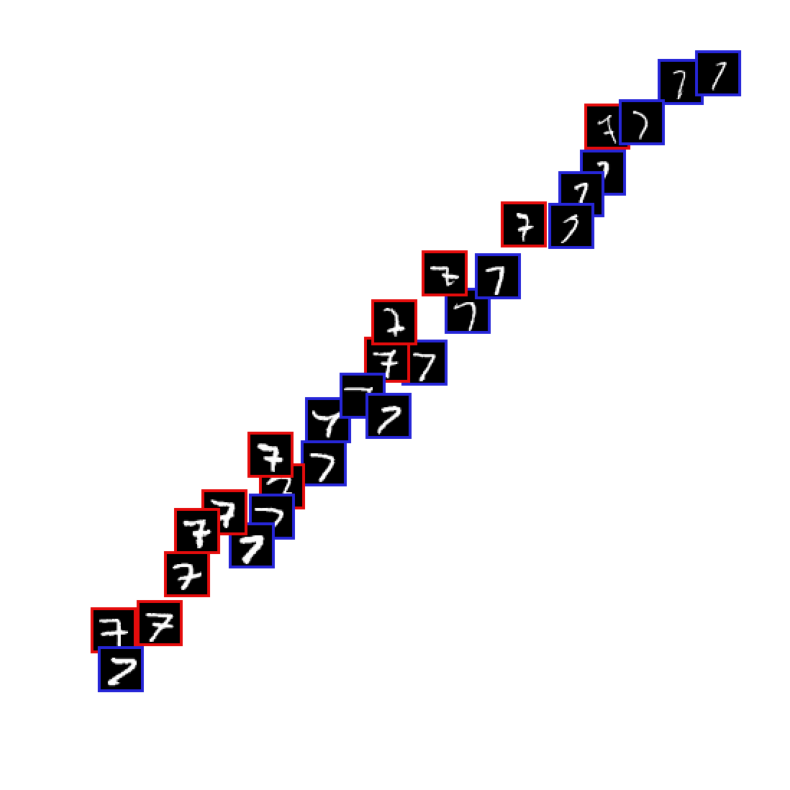

Epoch: 26 	Training Loss: -242.967291
Epoch: 27 	Training Loss: -243.992058
Epoch: 28 	Training Loss: -244.848102
Epoch: 29 	Training Loss: -245.562223
Epoch: 30 	Training Loss: -246.135758
Epoch: 31 	Training Loss: -246.614599
Epoch: 32 	Training Loss: -246.999107
Epoch: 33 	Training Loss: -247.324616
Epoch: 34 	Training Loss: -247.585264
Epoch: 35 	Training Loss: -247.781771
Epoch: 36 	Training Loss: -247.961239
Epoch: 37 	Training Loss: -248.093449
Epoch: 38 	Training Loss: -248.218736
Epoch: 39 	Training Loss: -248.343080
Epoch: 40 	Training Loss: -248.439716
Epoch: 41 	Training Loss: -248.533185
Epoch: 42 	Training Loss: -248.615065
Epoch: 43 	Training Loss: -248.694572
Epoch: 44 	Training Loss: -248.758626
Epoch: 45 	Training Loss: -248.842384
Epoch: 46 	Training Loss: -248.919728
Epoch: 47 	Training Loss: -248.994729
Epoch: 48 	Training Loss: -249.083152
Epoch: 49 	Training Loss: -249.171632
Epoch: 50 	Training Loss: -249.247210


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


------------------------------------------------------------------
KM balanced accuracy score with hand-crafted labels :  0.5605199164297702


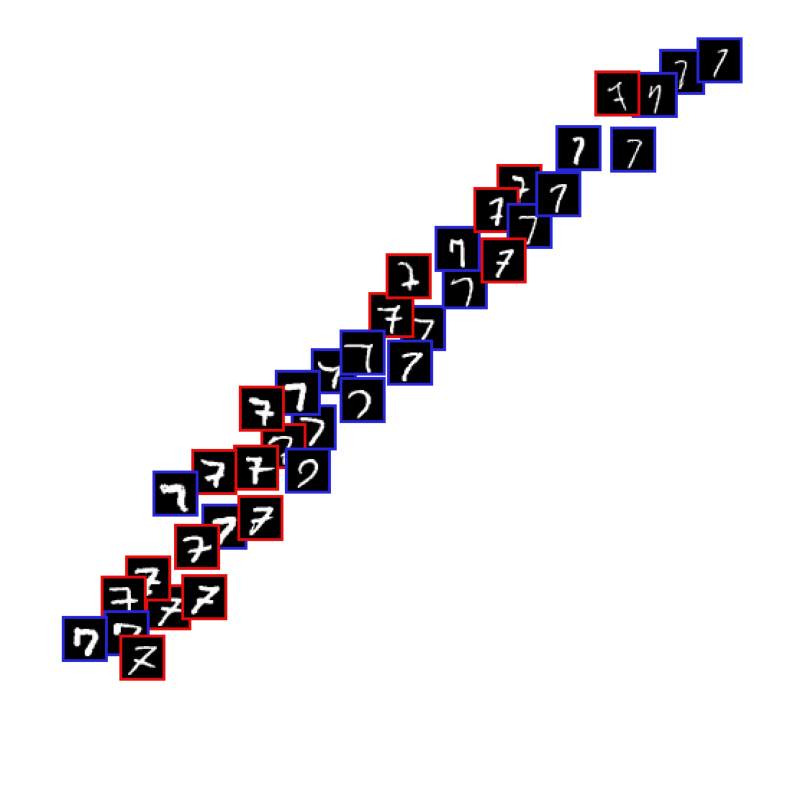

Epoch: 51 	Training Loss: -249.322898
Epoch: 52 	Training Loss: -249.390350
Epoch: 53 	Training Loss: -249.453321
Epoch: 54 	Training Loss: -249.513970
Epoch: 55 	Training Loss: -249.568501
Epoch: 56 	Training Loss: -249.618915
Epoch: 57 	Training Loss: -249.672797
Epoch: 58 	Training Loss: -249.721939
Epoch: 59 	Training Loss: -249.760953
Epoch: 60 	Training Loss: -249.806094
Epoch: 61 	Training Loss: -249.841137
Epoch: 62 	Training Loss: -249.876626
Epoch: 63 	Training Loss: -249.908250
Epoch: 64 	Training Loss: -249.941645
Epoch: 65 	Training Loss: -249.962452
Epoch: 66 	Training Loss: -249.990798
Epoch: 67 	Training Loss: -250.014145
Epoch: 68 	Training Loss: -250.035555
Epoch: 69 	Training Loss: -250.053041
Epoch: 70 	Training Loss: -250.073350
Epoch: 71 	Training Loss: -250.087308
Epoch: 72 	Training Loss: -250.104335
Epoch: 73 	Training Loss: -250.118217
Epoch: 74 	Training Loss: -250.127155
Epoch: 75 	Training Loss: -250.138280


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


------------------------------------------------------------------
KM balanced accuracy score with hand-crafted labels :  0.5555365277254513


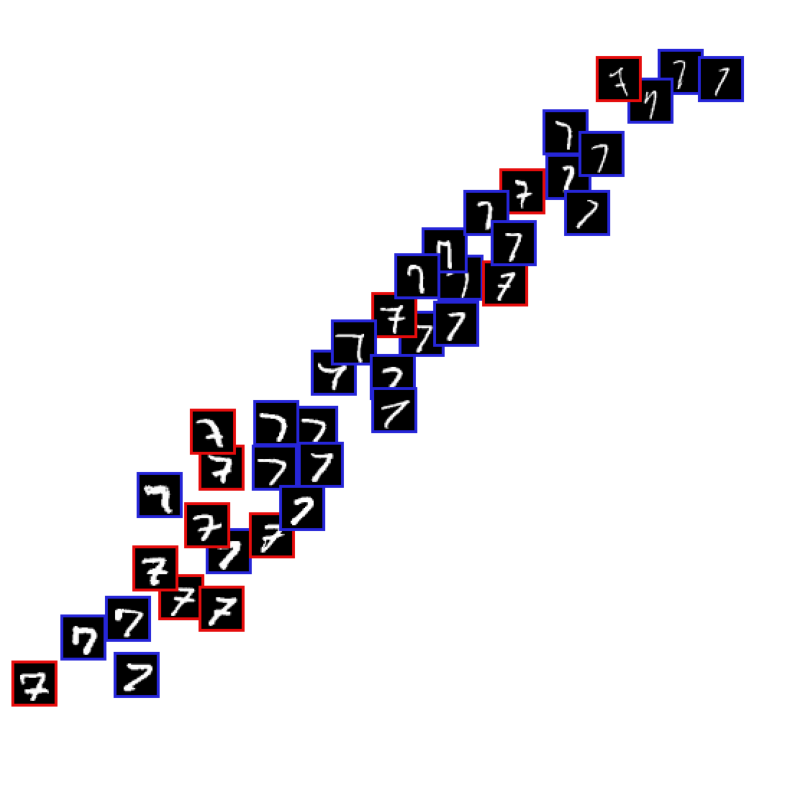

0:28:52.740254
------------------------------------------------------------------
Epoch: 1 	Training Loss: -16.226503
Epoch: 2 	Training Loss: -29.690517
Epoch: 3 	Training Loss: -42.395648
Epoch: 4 	Training Loss: -55.670227
Epoch: 5 	Training Loss: -69.516395
Epoch: 6 	Training Loss: -84.406827
Epoch: 7 	Training Loss: -100.504527
Epoch: 8 	Training Loss: -116.966121
Epoch: 9 	Training Loss: -133.047123
Epoch: 10 	Training Loss: -148.776508
Epoch: 11 	Training Loss: -163.704096
Epoch: 12 	Training Loss: -176.053460
Epoch: 13 	Training Loss: -186.159269
Epoch: 14 	Training Loss: -194.631283
Epoch: 15 	Training Loss: -201.747431
Epoch: 16 	Training Loss: -207.860329
Epoch: 17 	Training Loss: -213.238510
Epoch: 18 	Training Loss: -218.079873
Epoch: 19 	Training Loss: -222.418699
Epoch: 20 	Training Loss: -226.181157
Epoch: 21 	Training Loss: -229.480212
Epoch: 22 	Training Loss: -232.335445
Epoch: 23 	Training Loss: -234.831913
Epoch: 24 	Training Loss: -236.993437
Epoch: 25 	Training L

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


------------------------------------------------------------------
KM balanced accuracy score with hand-crafted labels :  0.5297633318491626


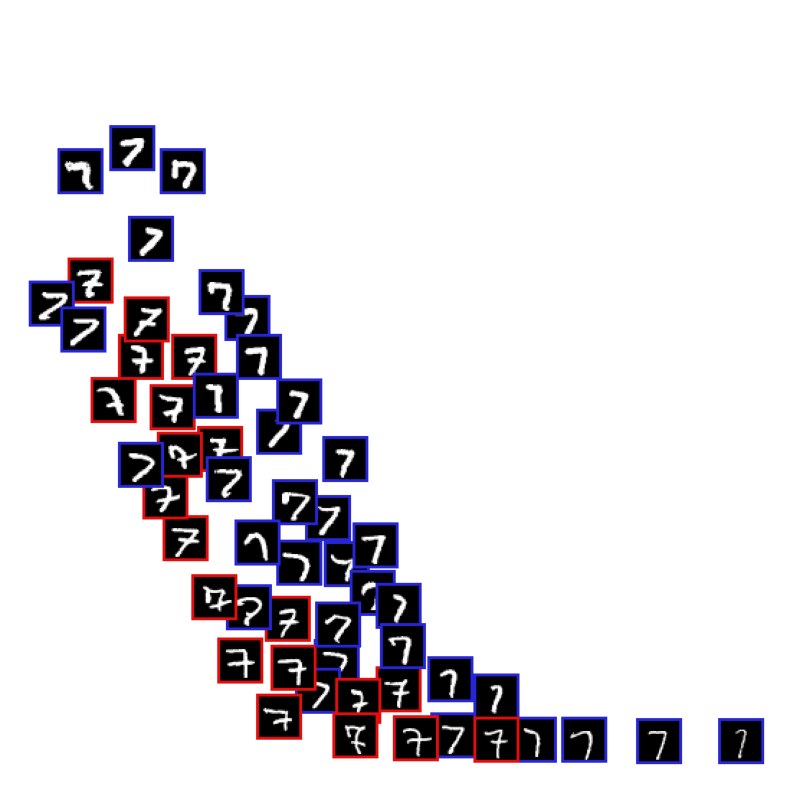

Epoch: 26 	Training Loss: -240.492799
Epoch: 27 	Training Loss: -241.870172
Epoch: 28 	Training Loss: -243.066557
Epoch: 29 	Training Loss: -244.099764
Epoch: 30 	Training Loss: -244.968578
Epoch: 31 	Training Loss: -245.672453
Epoch: 32 	Training Loss: -246.268237
Epoch: 33 	Training Loss: -246.743190
Epoch: 34 	Training Loss: -247.132332
Epoch: 35 	Training Loss: -247.445699
Epoch: 36 	Training Loss: -247.702690
Epoch: 37 	Training Loss: -247.910408
Epoch: 38 	Training Loss: -248.083162
Epoch: 39 	Training Loss: -248.227897
Epoch: 40 	Training Loss: -248.354456
Epoch: 41 	Training Loss: -248.466455
Epoch: 42 	Training Loss: -248.560113
Epoch: 43 	Training Loss: -248.648027
Epoch: 44 	Training Loss: -248.731761
Epoch: 45 	Training Loss: -248.807052
Epoch: 46 	Training Loss: -248.868469
Epoch: 47 	Training Loss: -248.928574
Epoch: 48 	Training Loss: -248.990469
Epoch: 49 	Training Loss: -249.042510
Epoch: 50 	Training Loss: -249.108491


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


------------------------------------------------------------------
KM balanced accuracy score with hand-crafted labels :  0.5537041476864062


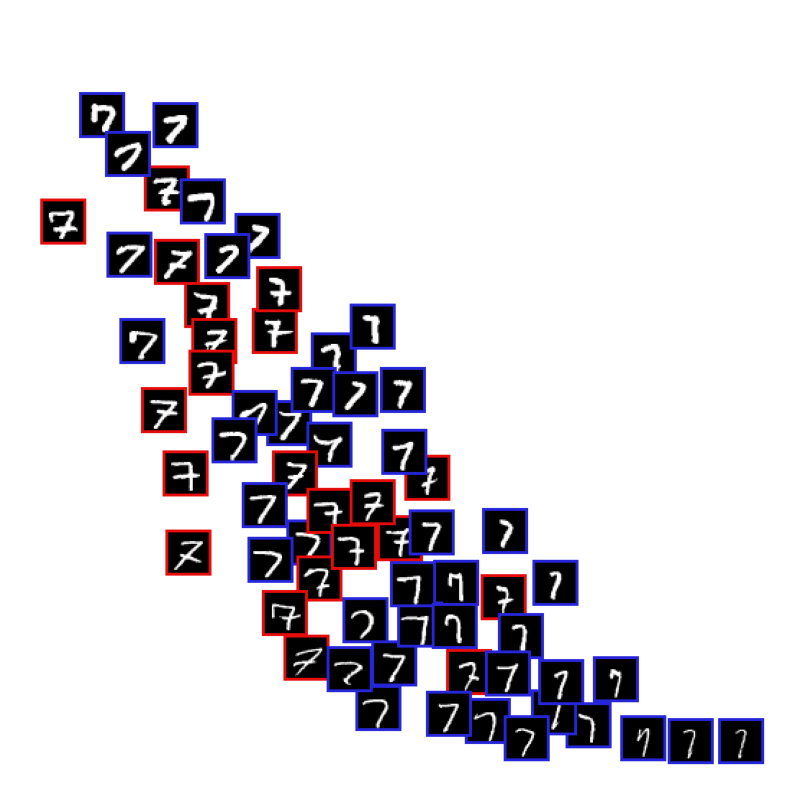

Epoch: 51 	Training Loss: -249.165533
Epoch: 52 	Training Loss: -249.230913
Epoch: 53 	Training Loss: -249.294204
Epoch: 54 	Training Loss: -249.355828
Epoch: 55 	Training Loss: -249.413635
Epoch: 56 	Training Loss: -249.473257
Epoch: 57 	Training Loss: -249.522236
Epoch: 58 	Training Loss: -249.569584
Epoch: 59 	Training Loss: -249.609940
Epoch: 60 	Training Loss: -249.654230
Epoch: 61 	Training Loss: -249.695767
Epoch: 62 	Training Loss: -249.732307
Epoch: 63 	Training Loss: -249.766895
Epoch: 64 	Training Loss: -249.795433
Epoch: 65 	Training Loss: -249.823284
Epoch: 66 	Training Loss: -249.849551
Epoch: 67 	Training Loss: -249.869051
Epoch: 68 	Training Loss: -249.888916
Epoch: 69 	Training Loss: -249.906927
Epoch: 70 	Training Loss: -249.919088
Epoch: 71 	Training Loss: -249.936018
Epoch: 72 	Training Loss: -249.941370
Epoch: 73 	Training Loss: -249.956379
Epoch: 74 	Training Loss: -249.960142
Epoch: 75 	Training Loss: -249.973731


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


------------------------------------------------------------------
KM balanced accuracy score with hand-crafted labels :  0.5468883789430421


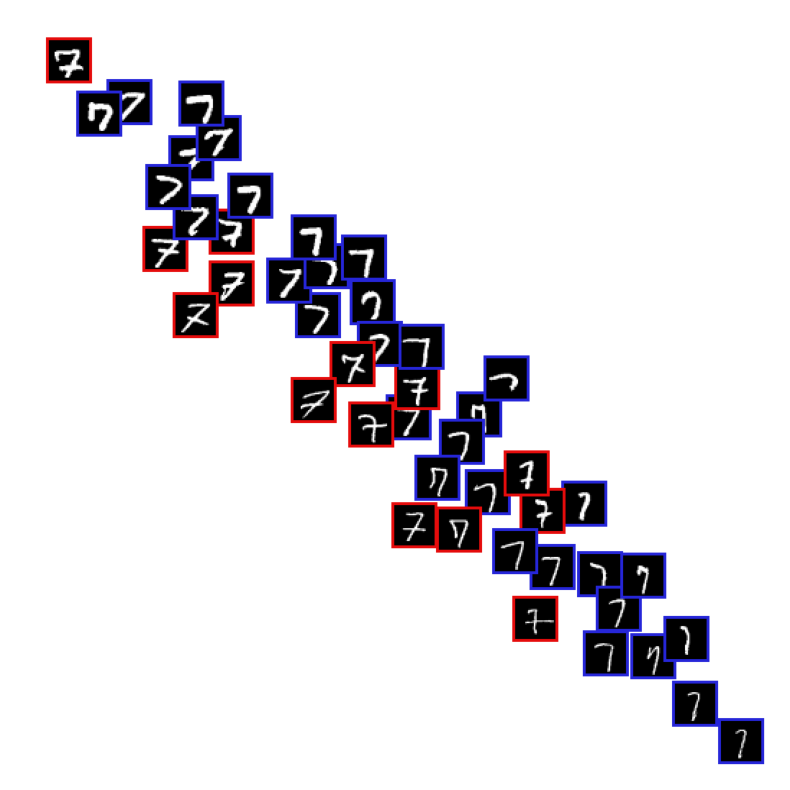

0:28:46.301461
------------------------------------------------------------------
Epoch: 1 	Training Loss: 25.126860
Epoch: 2 	Training Loss: 6.902002
Epoch: 3 	Training Loss: -10.788700
Epoch: 4 	Training Loss: -29.026592
Epoch: 5 	Training Loss: -48.100003
Epoch: 6 	Training Loss: -67.685097
Epoch: 7 	Training Loss: -86.970094
Epoch: 8 	Training Loss: -105.431261
Epoch: 9 	Training Loss: -122.494885
Epoch: 10 	Training Loss: -137.864670
Epoch: 11 	Training Loss: -151.204033
Epoch: 12 	Training Loss: -162.823373
Epoch: 13 	Training Loss: -173.131030
Epoch: 14 	Training Loss: -182.284211
Epoch: 15 	Training Loss: -190.483852
Epoch: 16 	Training Loss: -198.087391
Epoch: 17 	Training Loss: -204.845536
Epoch: 18 	Training Loss: -210.697177
Epoch: 19 	Training Loss: -215.760676
Epoch: 20 	Training Loss: -220.187583
Epoch: 21 	Training Loss: -224.046853
Epoch: 22 	Training Loss: -227.453626
Epoch: 23 	Training Loss: -230.436654
Epoch: 24 	Training Loss: -233.002869
Epoch: 25 	Training Loss:

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


------------------------------------------------------------------
KM balanced accuracy score with hand-crafted labels :  0.5603486659588314


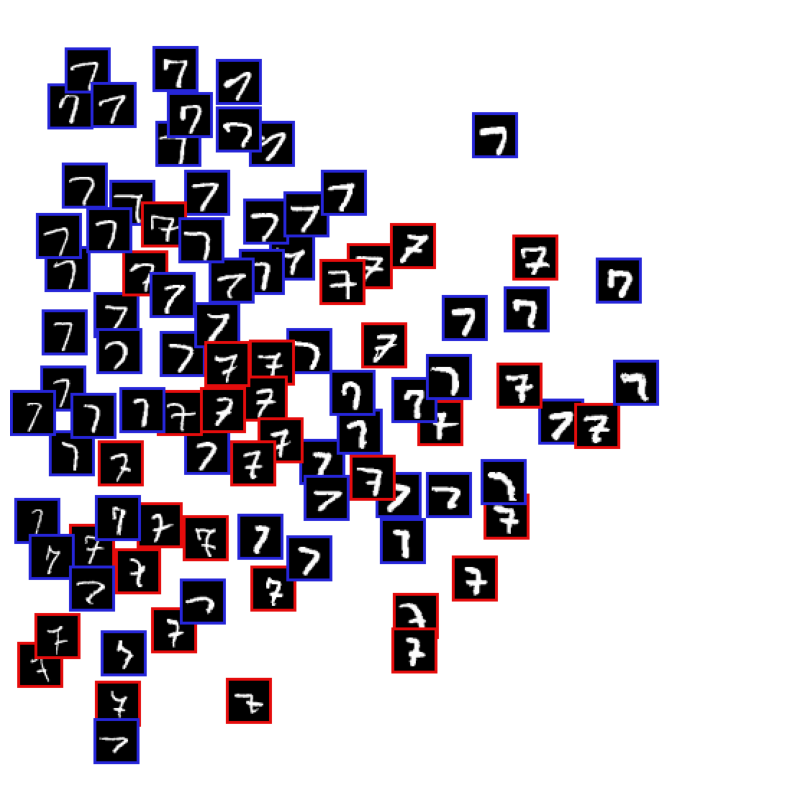

Epoch: 26 	Training Loss: -237.139984
Epoch: 27 	Training Loss: -238.882402
Epoch: 28 	Training Loss: -240.409902
Epoch: 29 	Training Loss: -241.710276
Epoch: 30 	Training Loss: -242.833270
Epoch: 31 	Training Loss: -243.776319
Epoch: 32 	Training Loss: -244.597119
Epoch: 33 	Training Loss: -245.292391
Epoch: 34 	Training Loss: -245.895328
Epoch: 35 	Training Loss: -246.408359
Epoch: 36 	Training Loss: -246.846361
Epoch: 37 	Training Loss: -247.228954
Epoch: 38 	Training Loss: -247.547843
Epoch: 39 	Training Loss: -247.812104
Epoch: 40 	Training Loss: -248.032206
Epoch: 41 	Training Loss: -248.218251
Epoch: 42 	Training Loss: -248.365119
Epoch: 43 	Training Loss: -248.496017
Epoch: 44 	Training Loss: -248.593243
Epoch: 45 	Training Loss: -248.689264
Epoch: 46 	Training Loss: -248.762389
Epoch: 47 	Training Loss: -248.830220
Epoch: 48 	Training Loss: -248.882058
Epoch: 49 	Training Loss: -248.933120
Epoch: 50 	Training Loss: -248.987291


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


------------------------------------------------------------------
KM balanced accuracy score with hand-crafted labels :  0.5656745556050279


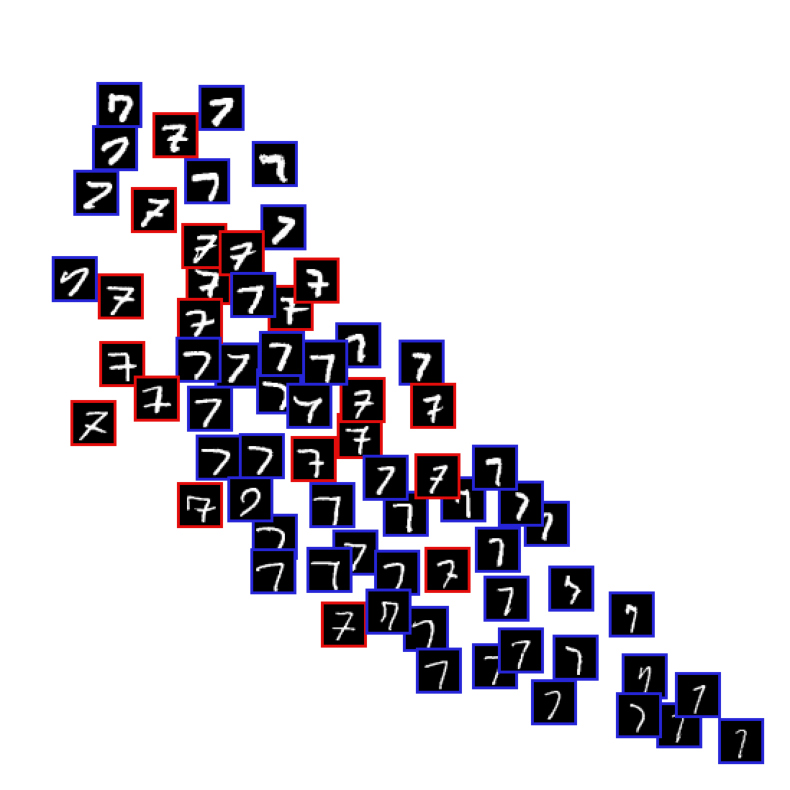

Epoch: 51 	Training Loss: -249.027955
Epoch: 52 	Training Loss: -249.074116
Epoch: 53 	Training Loss: -249.108538
Epoch: 54 	Training Loss: -249.144622
Epoch: 55 	Training Loss: -249.175904
Epoch: 56 	Training Loss: -249.204626
Epoch: 57 	Training Loss: -249.235887
Epoch: 58 	Training Loss: -249.268087
Epoch: 59 	Training Loss: -249.297309
Epoch: 60 	Training Loss: -249.333521
Epoch: 61 	Training Loss: -249.359890
Epoch: 62 	Training Loss: -249.384744
Epoch: 63 	Training Loss: -249.411356
Epoch: 64 	Training Loss: -249.444942
Epoch: 65 	Training Loss: -249.461269
Epoch: 66 	Training Loss: -249.486654
Epoch: 67 	Training Loss: -249.504234
Epoch: 68 	Training Loss: -249.527011
Epoch: 69 	Training Loss: -249.549335
Epoch: 70 	Training Loss: -249.565132
Epoch: 71 	Training Loss: -249.589737
Epoch: 72 	Training Loss: -249.604849
Epoch: 73 	Training Loss: -249.627069
Epoch: 74 	Training Loss: -249.647234
Epoch: 75 	Training Loss: -249.666599


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


------------------------------------------------------------------
KM balanced accuracy score with hand-crafted labels :  0.5450559989039969


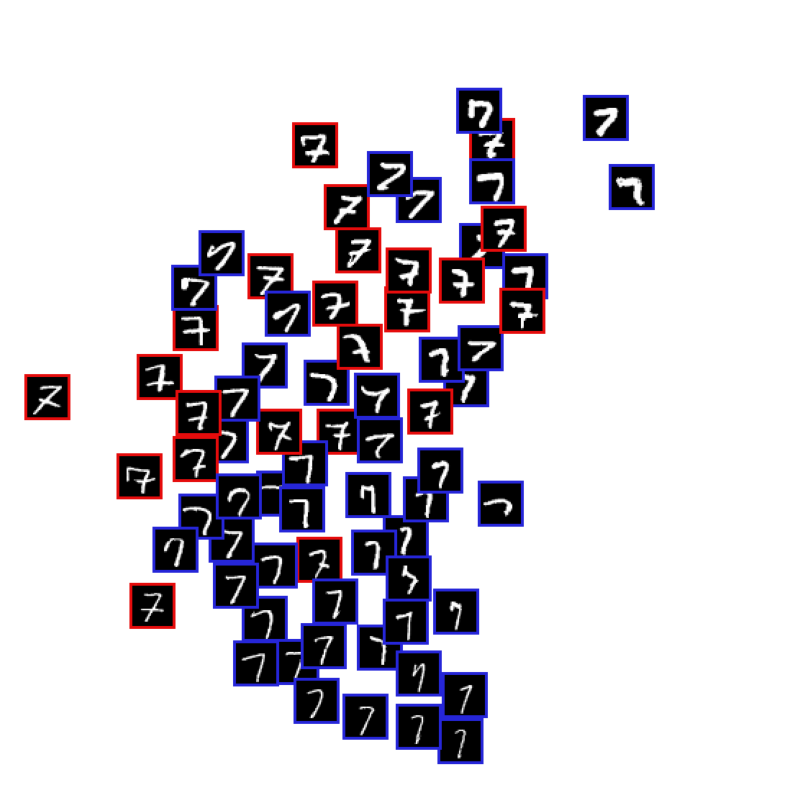

0:28:41.052962
------------------------------------------------------------------


In [ ]:
import datetime
import copy

# number of epochs to train the model
n_epochs = 75
lr = 0.00001
batch_size = 256

for run in range(0, 3) :
  begin_time = datetime.datetime.now()

  # build model
  conditional_classifier_model = SimpleConditionalConvNet(nc, nz, n_clusters).float().cuda()

  # build model
  teacher = SimpleConditionalConvNet(nc, nz, n_clusters).float().cuda()

  # dataloaders
  train_data = MyDataset(X_train)
  test_data = MyDataset(X_test, test=True)
  # prepare data loaders
  train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

  # specify loss function
  list_of_parameters = []
  list_of_parameters.extend(conditional_classifier_model.parameters())
  optimizer = torch.optim.Adam(list_of_parameters, lr=lr)

  train_losses = []
  test_losses = []
  test_accuracies = []
  train_accuracies = []

  for epoch in range(1, n_epochs+1):
      # monitor training loss
      train_loss = 0.0
      test_loss = 0.0

      ###################
      # train the model #
      ###################
      conditional_classifier_model.train()
      train_accuracy=0.0
      for data in train_loader:
          # _ stands in for labels, here no need to flatten images
          images_1, images_2 = data
          # clear the gradients of all optimized variables
          optimizer.zero_grad()
          # forward pass: compute predicted outputs by passing inputs to the model
          _, z1, _ = teacher(images_1)
          _, z2, _ = teacher(images_2)

          _, _, p1 = conditional_classifier_model(images_1)
          _, _, p2 = conditional_classifier_model(images_2)

          loss = - nn.functional.cosine_similarity(p1, z2.detach(), dim=-1).mean()
          loss += - nn.functional.cosine_similarity(p2, z1.detach(), dim=-1).mean()
          loss /= 2
          # backward pass: compute gradient of the loss with respect to model parameters
          loss.backward()
          # perform a single optimization step (parameter update)
          optimizer.step()
          # update running training loss
          train_loss += loss.item()*images_1.size(0)

      for student_params, teacher_params in zip(conditional_classifier_model.parameters(), teacher.parameters()):
          old_weight, up_weight = teacher_params.data, student_params.data
          teacher_params.data = ema.update_average(old_weight, up_weight)

      # print avg training statistics
      train_loss = train_loss/len(train_loader)
      #
      train_losses.append(train_loss)
      print('Epoch: {} \tTraining Loss: {:.6f}'.format(
          epoch,
          train_loss
          ))

      if epoch % 25 == 0:
        conditional_classifier_model.eval()
        with torch.no_grad():
            # EVALUATE THE MODEL
            train_data = MyDataset(X_train, test=True)
            test_data = MyDataset(X_test, test=True)
            train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
            test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)
            with torch.no_grad() :
              # TRAIN
              X_train_latent = torch.zeros((0, nz), device="cuda")
              for data in train_loader:
                  images, _ = data
                  encoded_vectors, _, _ = conditional_classifier_model.forward(images)
                  X_train_latent = torch.cat((X_train_latent, encoded_vectors), dim=0)
              # TEST
              X_test_latent = torch.zeros((0, nz), device="cuda")
              for data in test_loader:
                  images, _ = data
                  encoded_vectors, _, _ = conditional_classifier_model.forward(images)
                  X_test_latent = torch.cat((X_test_latent, encoded_vectors), dim=0)
              X_train_latent = X_train_latent.cpu().numpy()
              X_test_latent = X_test_latent.cpu().numpy()

        # Scaler
        scaler = RobustScaler().fit(X_train_latent)
        X_train_latent = scaler.transform(X_train_latent)
        X_test_latent = scaler.transform(X_test_latent)

        # KMeans training
        KMeans_method = KMeans(n_clusters=2).fit(X_train_latent)
        barycenters = KMeans_method.cluster_centers_
        print('------------------------------------------------------------------')
        y_train_clustering_pseudo_labels = np.array([np.linalg.norm(barycenter[None]-X_train_latent, axis=1) for barycenter in barycenters]).T
        y_train_clustering_pseudo_labels = y_train_clustering_pseudo_labels / np.sum(y_train_clustering_pseudo_labels, 1)[:,None]

        y_test_clustering_pseudo_labels = np.array([np.linalg.norm(barycenter[None]-X_test_latent, axis=1) for barycenter in barycenters]).T
        y_test_clustering_pseudo_labels = y_test_clustering_pseudo_labels / np.sum(y_test_clustering_pseudo_labels, 1)[:,None]

        print("KM balanced accuracy score with hand-crafted labels : ",
              max(balanced_accuracy_score(y_ground_truth, np.argmax(y_test_clustering_pseudo_labels[:len(y_ground_truth)], 1)),
              balanced_accuracy_score(1-y_ground_truth, np.argmax(y_test_clustering_pseudo_labels[:len(y_ground_truth)], 1)))
              )

        # PCA
        pca = PCA().fit(X_train_latent)
        X_test_latent_pca = pca.transform(X_test_latent)
        create_visualization(X_test_latent, X_test, 7*np.ones_like(np.argmax(y_test_clustering_pseudo_labels, axis=1)), y_ground_truth, np.argmax(y_test_clustering_pseudo_labels, axis=1))

        # train dataloaders
        train_data = MyDataset(X_train)
        train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
        # test dataloaders
        test_data = MyDataset(X_test)
        test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

  print(datetime.datetime.now() - begin_time)


  print('------------------------------------------------------------------')

In [ ]:
byol_results = []

print(np.mean(byol_results))
print(np.std(byol_results))

nan
nan


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
print(datetime.datetime.now() - begin_time)
# 0:27:46.132543

0:28:41.093337
